In [1]:
import torch, torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_folders = sorted(glob('D:/Program Files (x86)/Softcom/Train_Spects/*'))
len(train_folders)

7

In [4]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

C:\Users\tanve\AppData\Local\Temp\ipykernel_35596\2684945866.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  images = torch.as_tensor(images)


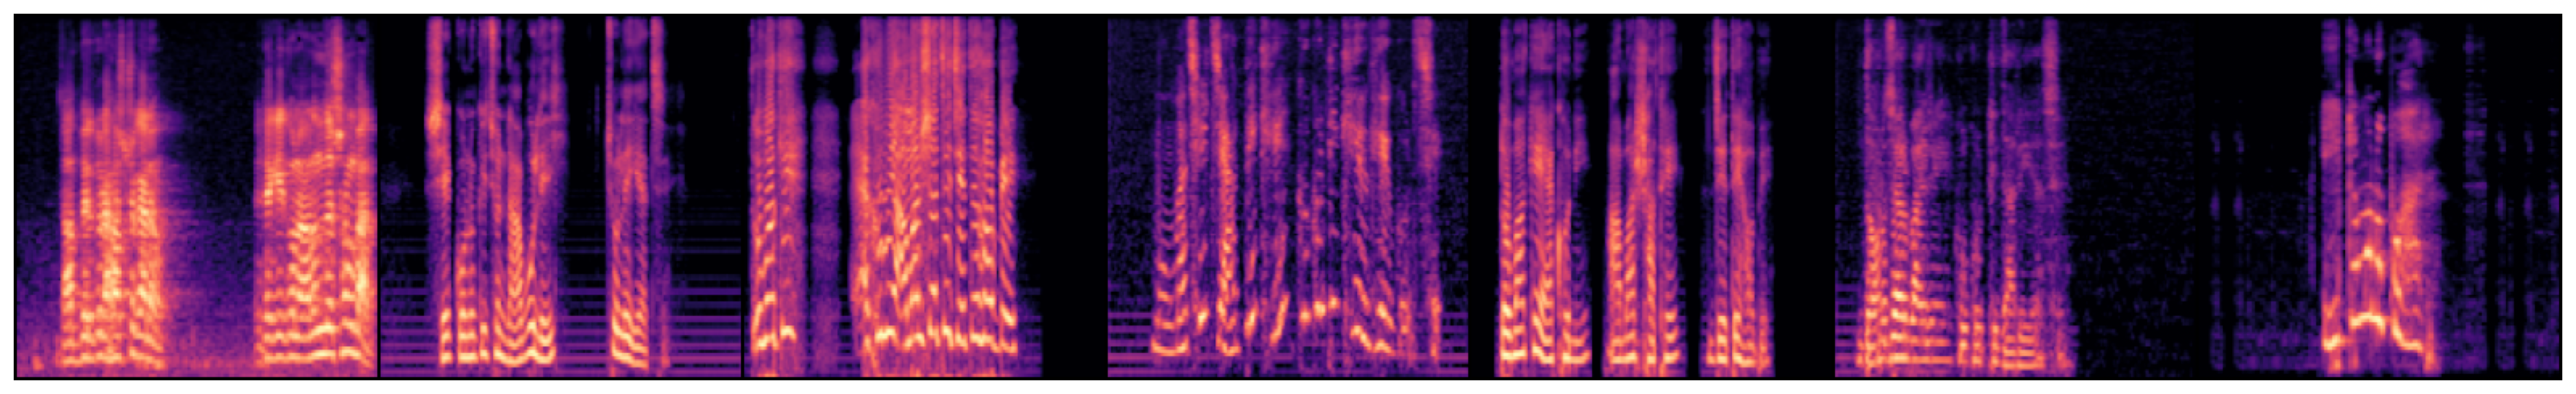

In [5]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

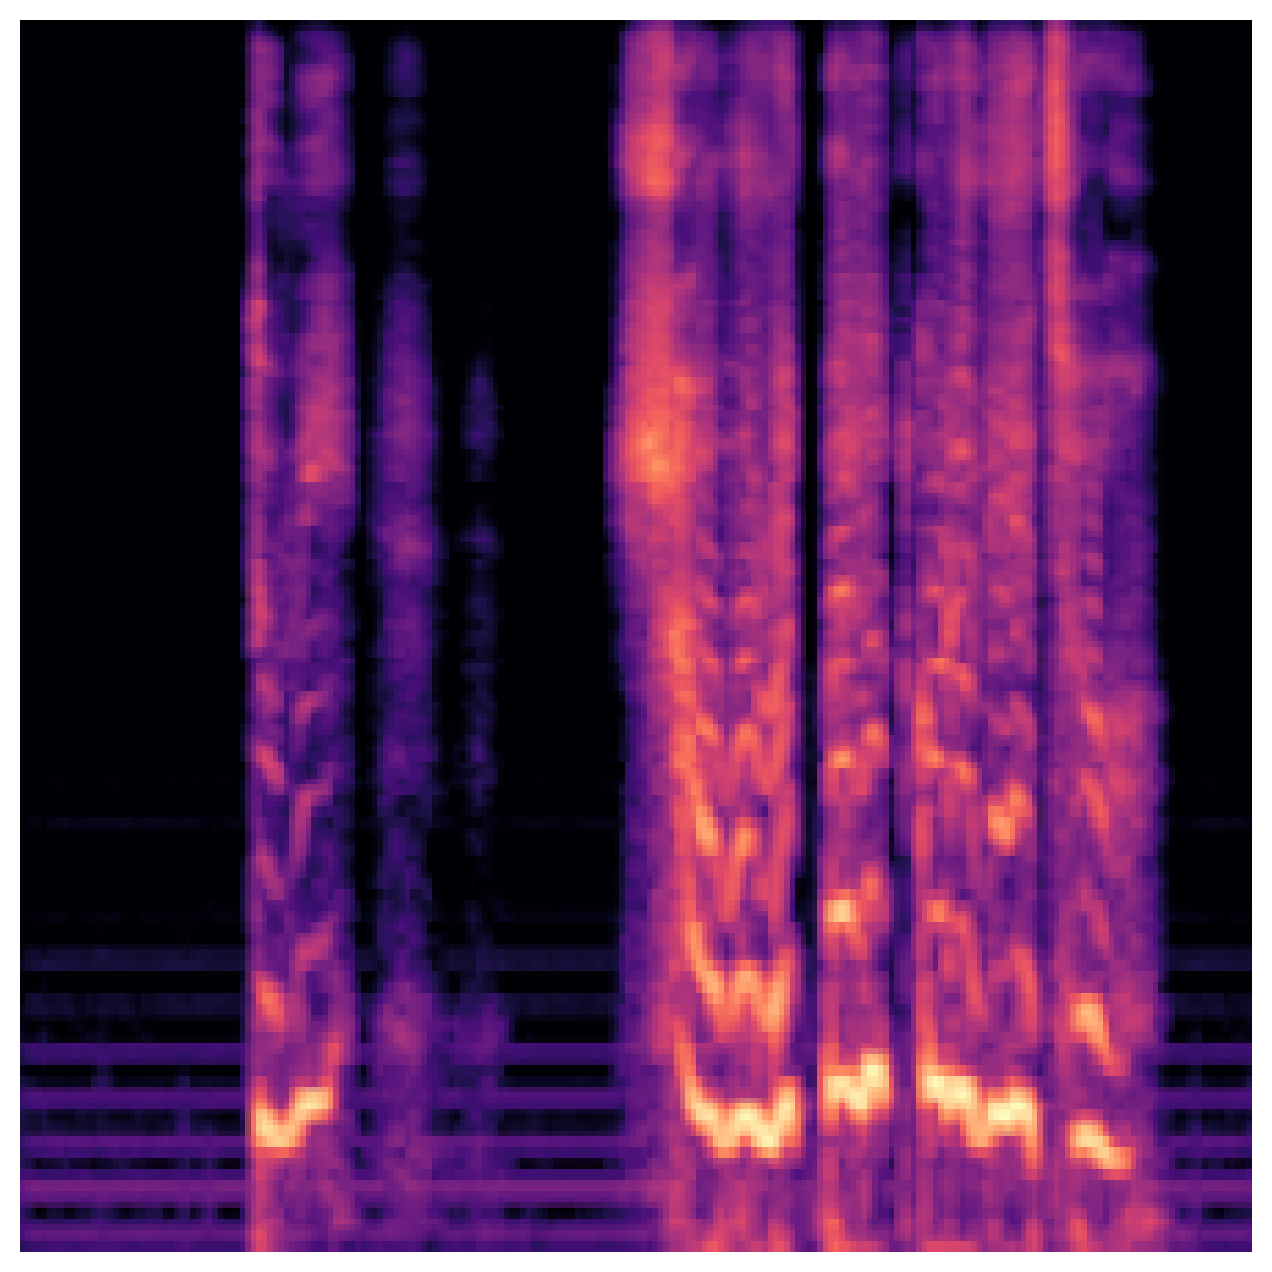

In [6]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [7]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [8]:
import subprocess
from pathlib import Path

DATA_DIR = Path('train_data')
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)
    print("CLeared")

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
DATASETS = ['train', 'val']

# Recreate the directory structure
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

CLeared


In [9]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths))] #Data Split Ratio here:
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 2710
Disgust: 2160
Fear: 1800
Happy: 2710
Neutral: 2416
Sad: 2710
Surprise: 2350


In [10]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [11]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=32, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [12]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 13484, 'val': 3372}

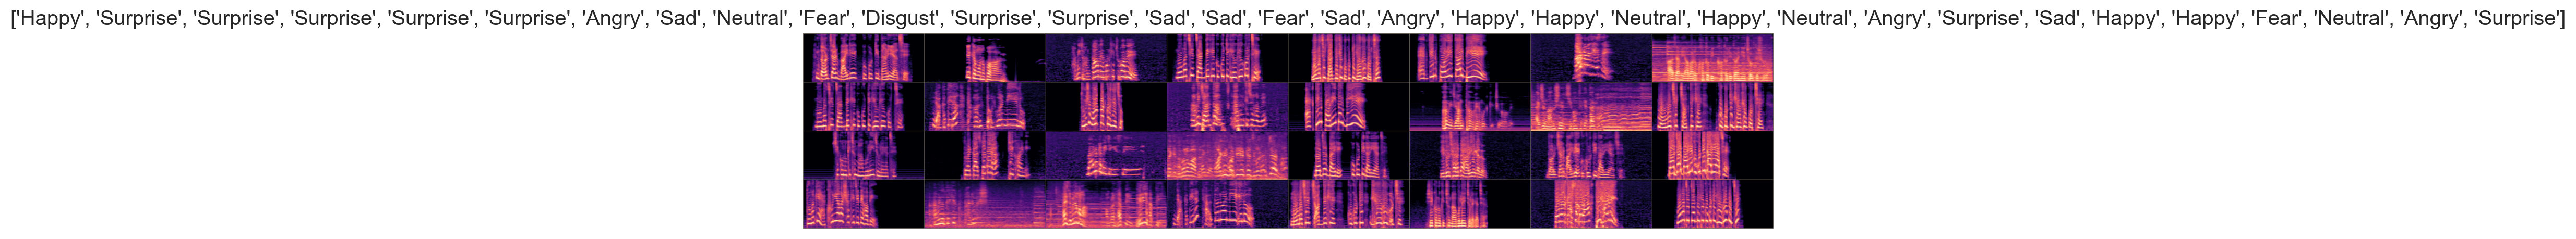

In [13]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation_func=nn.ReLU, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.activation = activation_func()
        self.dropout = nn.Dropout(dropout_rate)
        self.projection = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.projection(x)
        out = self.fc(x)
        out = self.bn(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

def create_model(n_classes, dropout_rates=[0.1, 0.2, 0.3, 0.4, 0.5]):
    model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        ResidualBlock(n_features, 512, dropout_rate=dropout_rates[0]),
        ResidualBlock(512, 256, dropout_rate=dropout_rates[1]),
        ResidualBlock(256, 128, dropout_rate=dropout_rates[2]),
        ResidualBlock(128, 64, dropout_rate=dropout_rates[3]),
        ResidualBlock(64, 32, dropout_rate=dropout_rates[4]),
        nn.Linear(32, n_classes) 
    )

    return model.to(device)

In [15]:
base_model = create_model(len(class_names))

In [16]:
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
base_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
from tqdm.notebook import tqdm

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  batch_progress = tqdm(data_loader, desc='Training', leave=False)

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
    batch_progress.update(1)

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  batch_progress = tqdm(data_loader, desc='Evaluation', leave=False)
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      batch_progress.set_postfix(loss=np.mean(losses), accuracy=(correct_predictions.double() / n_examples).item())
      batch_progress.update(1)
  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=12): #Epoch
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [21]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 1.3391462865316472 accuracy 0.4854642539305844


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.8657933788479499 accuracy 0.6666666666666667

Epoch 2/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.6612468901403707 accuracy 0.7567487392465144


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.5371652318621581 accuracy 0.7965599051008304

Epoch 3/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.3582938767934298 accuracy 0.8738504894690003


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.47348697750635865 accuracy 0.8351126927639384

Epoch 4/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.20036467475048597 accuracy 0.9331059032927915


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.42502516557304365 accuracy 0.8552787663107948

Epoch 5/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.1416552738370418 accuracy 0.9523880154256897


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.40798322624474204 accuracy 0.8656583629893239

Epoch 6/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.10933393700229295 accuracy 0.9633639869474934


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.3164324676442259 accuracy 0.9042111506524318

Epoch 7/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.08305822073270112 accuracy 0.9714476416493623


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.4471601242867281 accuracy 0.8721826809015422

Epoch 8/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.03360793803337414 accuracy 0.9902106199940671


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.1873726906992917 accuracy 0.9397983392645315

Epoch 9/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.017216098627105346 accuracy 0.9951794719667755


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.1825589847944255 accuracy 0.9403914590747332

Epoch 10/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.01288826786540559 accuracy 0.9973301690892911


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.16696309946468627 accuracy 0.9507710557532623

Epoch 11/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.01114439719256733 accuracy 0.9979976268169684


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.16982542283674879 accuracy 0.9501779359430605

Epoch 12/12
----------


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Train loss 0.009407895289803413 accuracy 0.998220112726194


Evaluation:   0%|          | 0/106 [00:00<?, ?it/s]

Val   loss 0.16182091493018955 accuracy 0.949288256227758

Best val accuracy: 0.9507710557532623
CPU times: total: 12min 27s
Wall time: 29min 17s


In [22]:
checkpoint_path = 'D:/Program Files (x86)/Softcom/ResNet101_Custom3.pth'
torch.save(base_model.state_dict(), checkpoint_path)

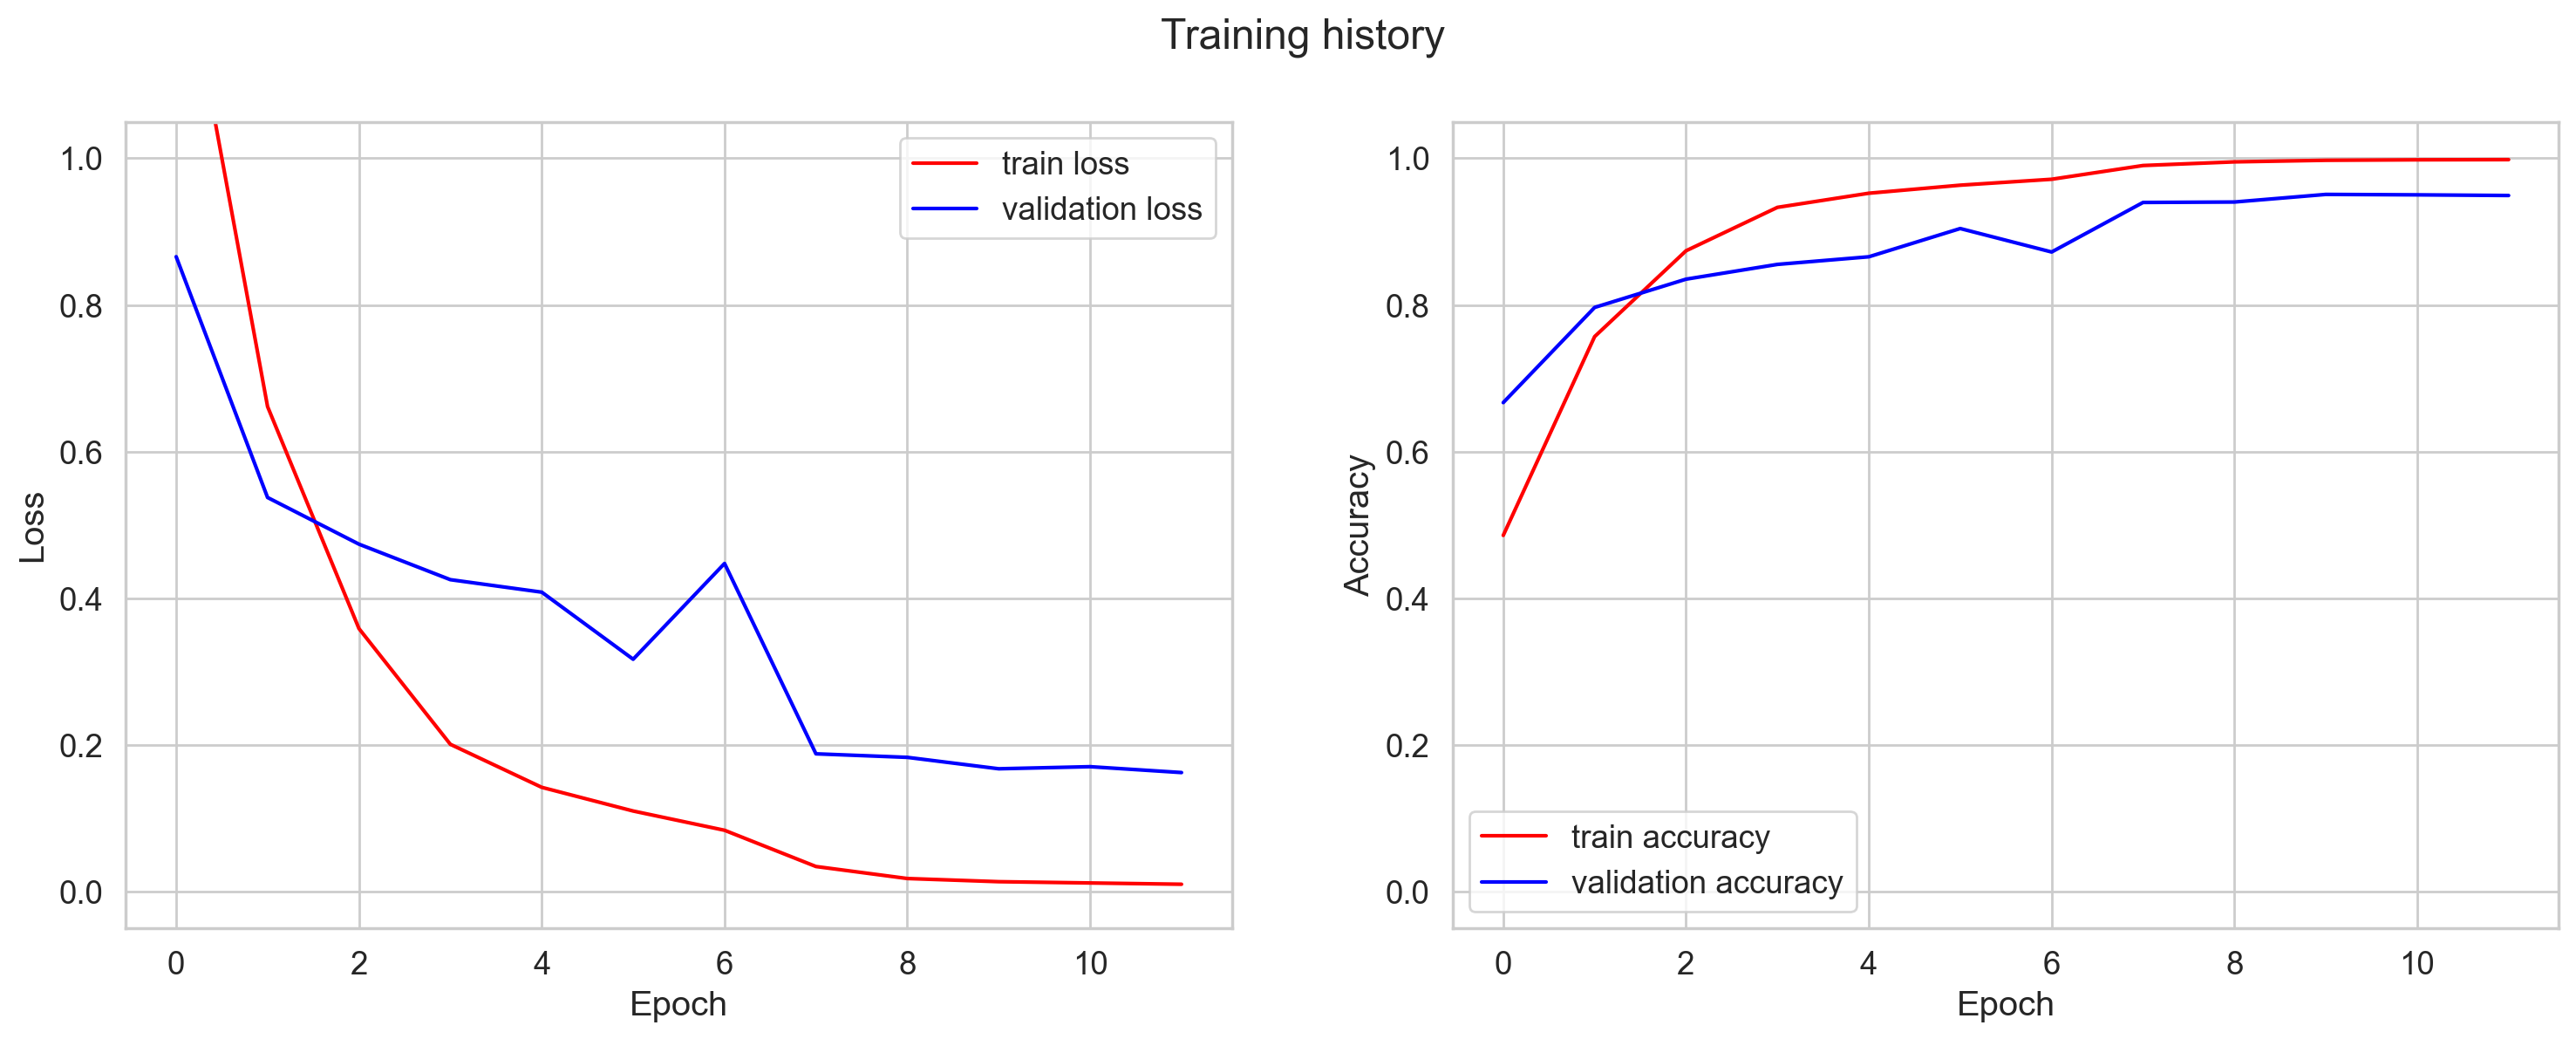

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plotting loss
    ax1.plot(history['train_loss'], label='train loss', color="red")
    ax1.plot(history['val_loss'], label='validation loss', color="blue")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    # Ensuring that tensors are on CPU and converting to NumPy arrays for plotting
    train_acc = [x.cpu().numpy() if x.is_cuda else x.numpy() for x in history['train_acc']]
    val_acc = [x.cpu().numpy() if x.is_cuda else x.numpy() for x in history['val_acc']]

    # Plotting accuracy
    ax2.plot(train_acc, label='train accuracy', color="red")
    ax2.plot(val_acc, label='validation accuracy', color="blue")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

# Assuming 'history' is a dictionary containing your training history
plot_training_history(history)


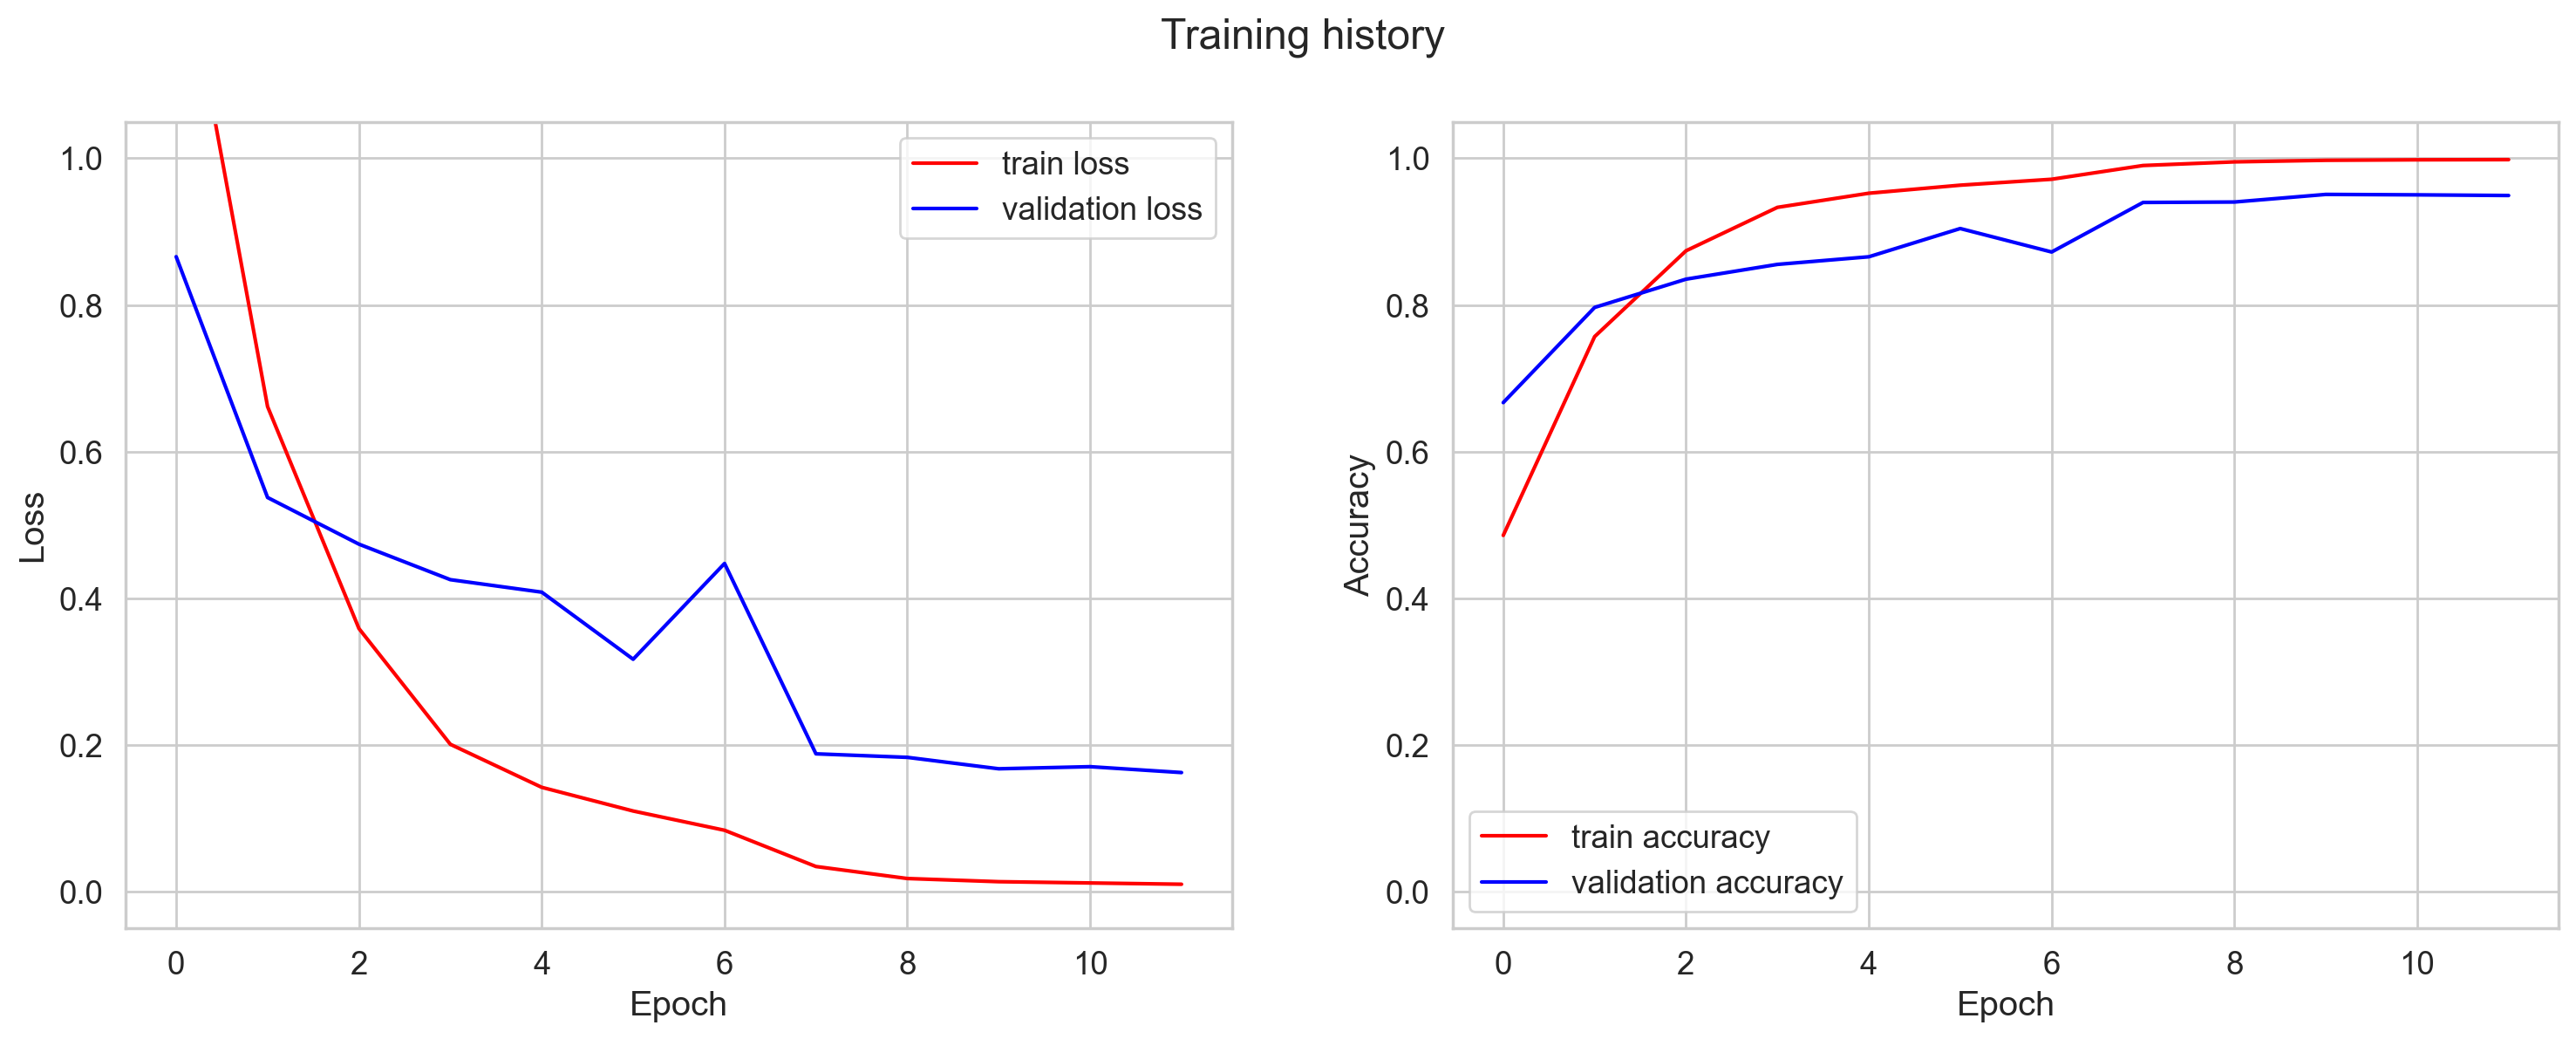

In [24]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [25]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [26]:
test_folders = sorted(glob('D:/Program Files (x86)/Softcom/Test_Spects/*'))
len(test_folders)
#E:/Thesis/Seg2_test_set_classified/0-25/* done
#E:/Thesis/Seg2_test_set_classified/25-50/* done
#E:/Thesis/Seg2_test_set_classified/50plus/* done
#E:/Thesis/Seg2_test_set/*

7

In [27]:
base_model = create_model(len(class_names))

checkpoint_path = 'D:/Program Files (x86)/Softcom/ResNet101_Custom3.pth'
checkpoint = torch.load(checkpoint_path)

base_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
base_model.to(device)
base_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

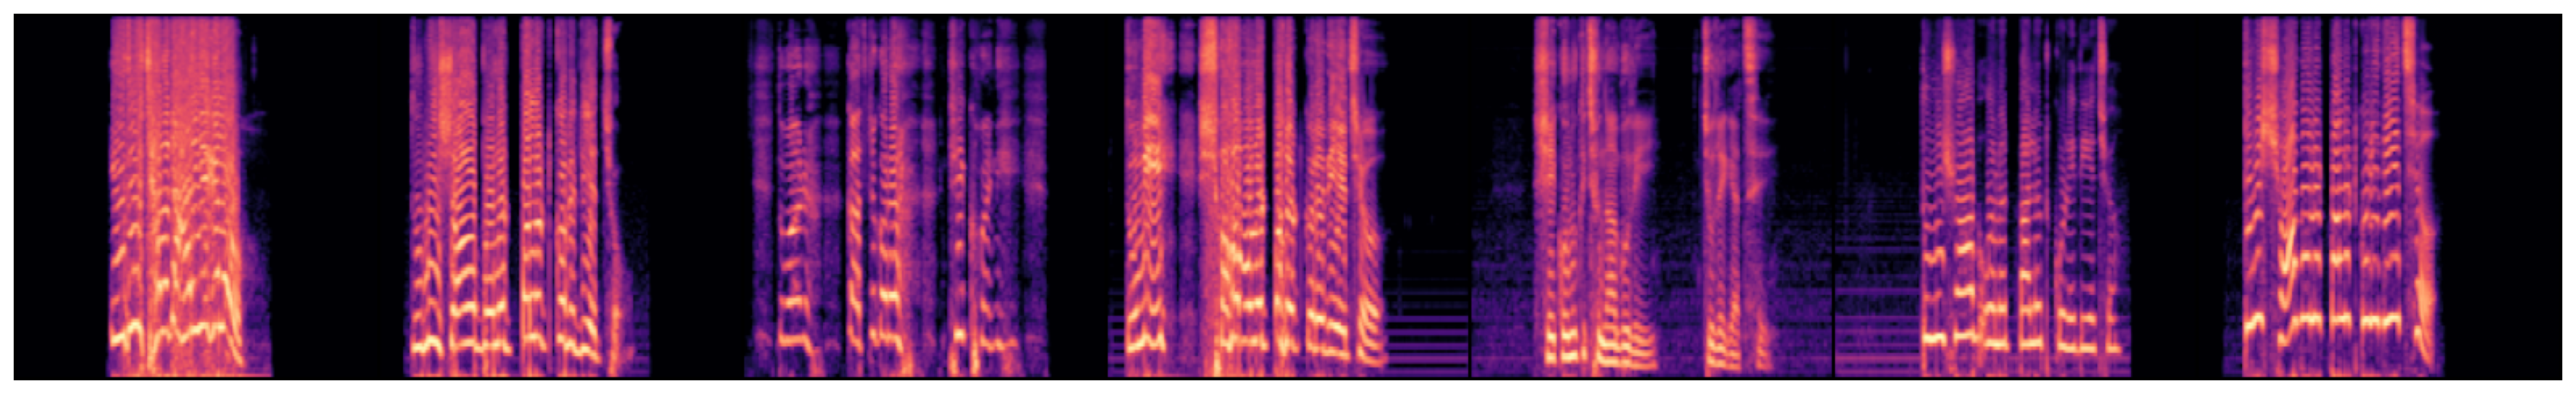

In [29]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

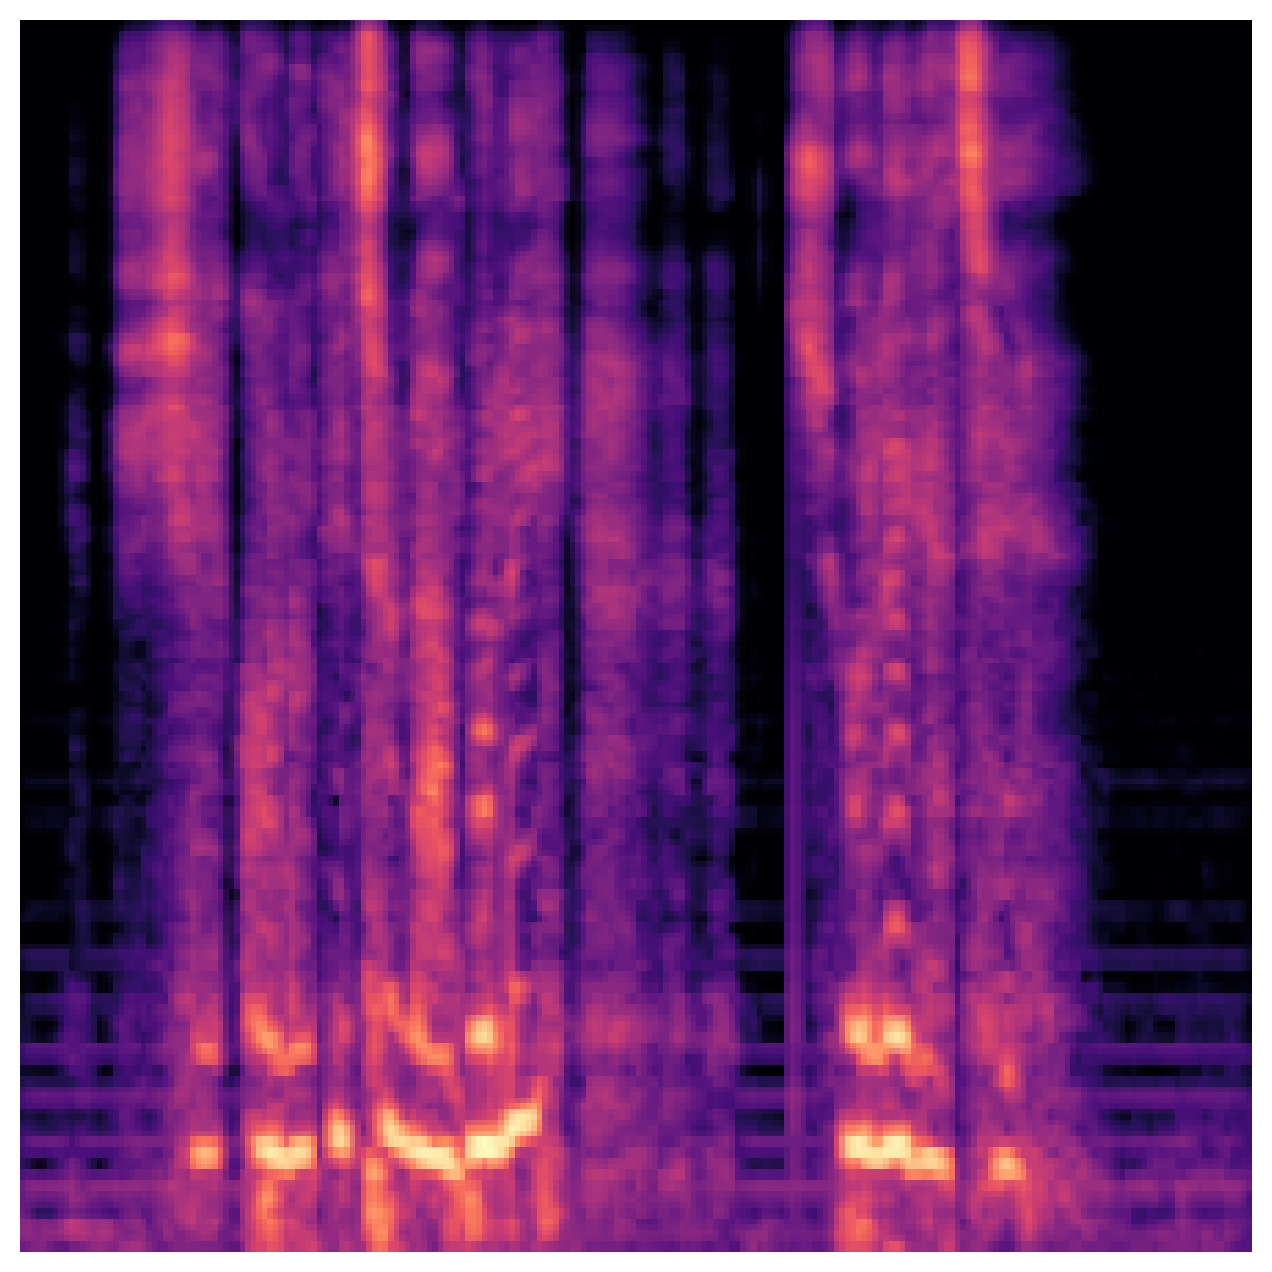

In [30]:
img_path = glob(f'{test_folders[2]}/*png')[1]

show_image(img_path)

In [31]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

class_indices = [0, 1, 2, 3, 4, 5, 6]

In [32]:
import subprocess
from pathlib import Path

# It's safer to check if the directory exists and then remove it using Python's built-in functions
DATA_DIR = Path('test_data')
if DATA_DIR.exists() and DATA_DIR.is_dir():
    shutil.rmtree(DATA_DIR)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
DATASETS = ['test']

# Recreate the directory structure
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [33]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Angry: 151
Disgust: 120
Fear: 100
Happy: 151
Neutral: 135
Sad: 151
Surprise: 131


In [34]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [35]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [36]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 939}

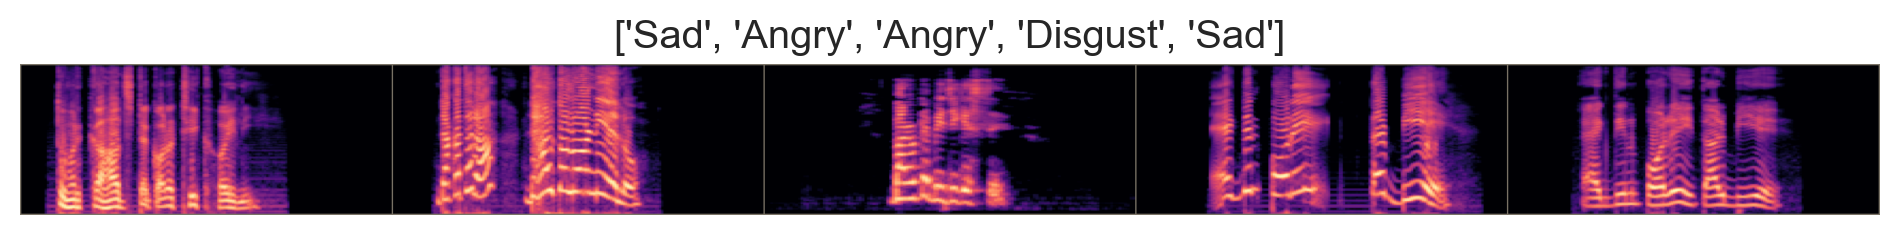

In [37]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [38]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

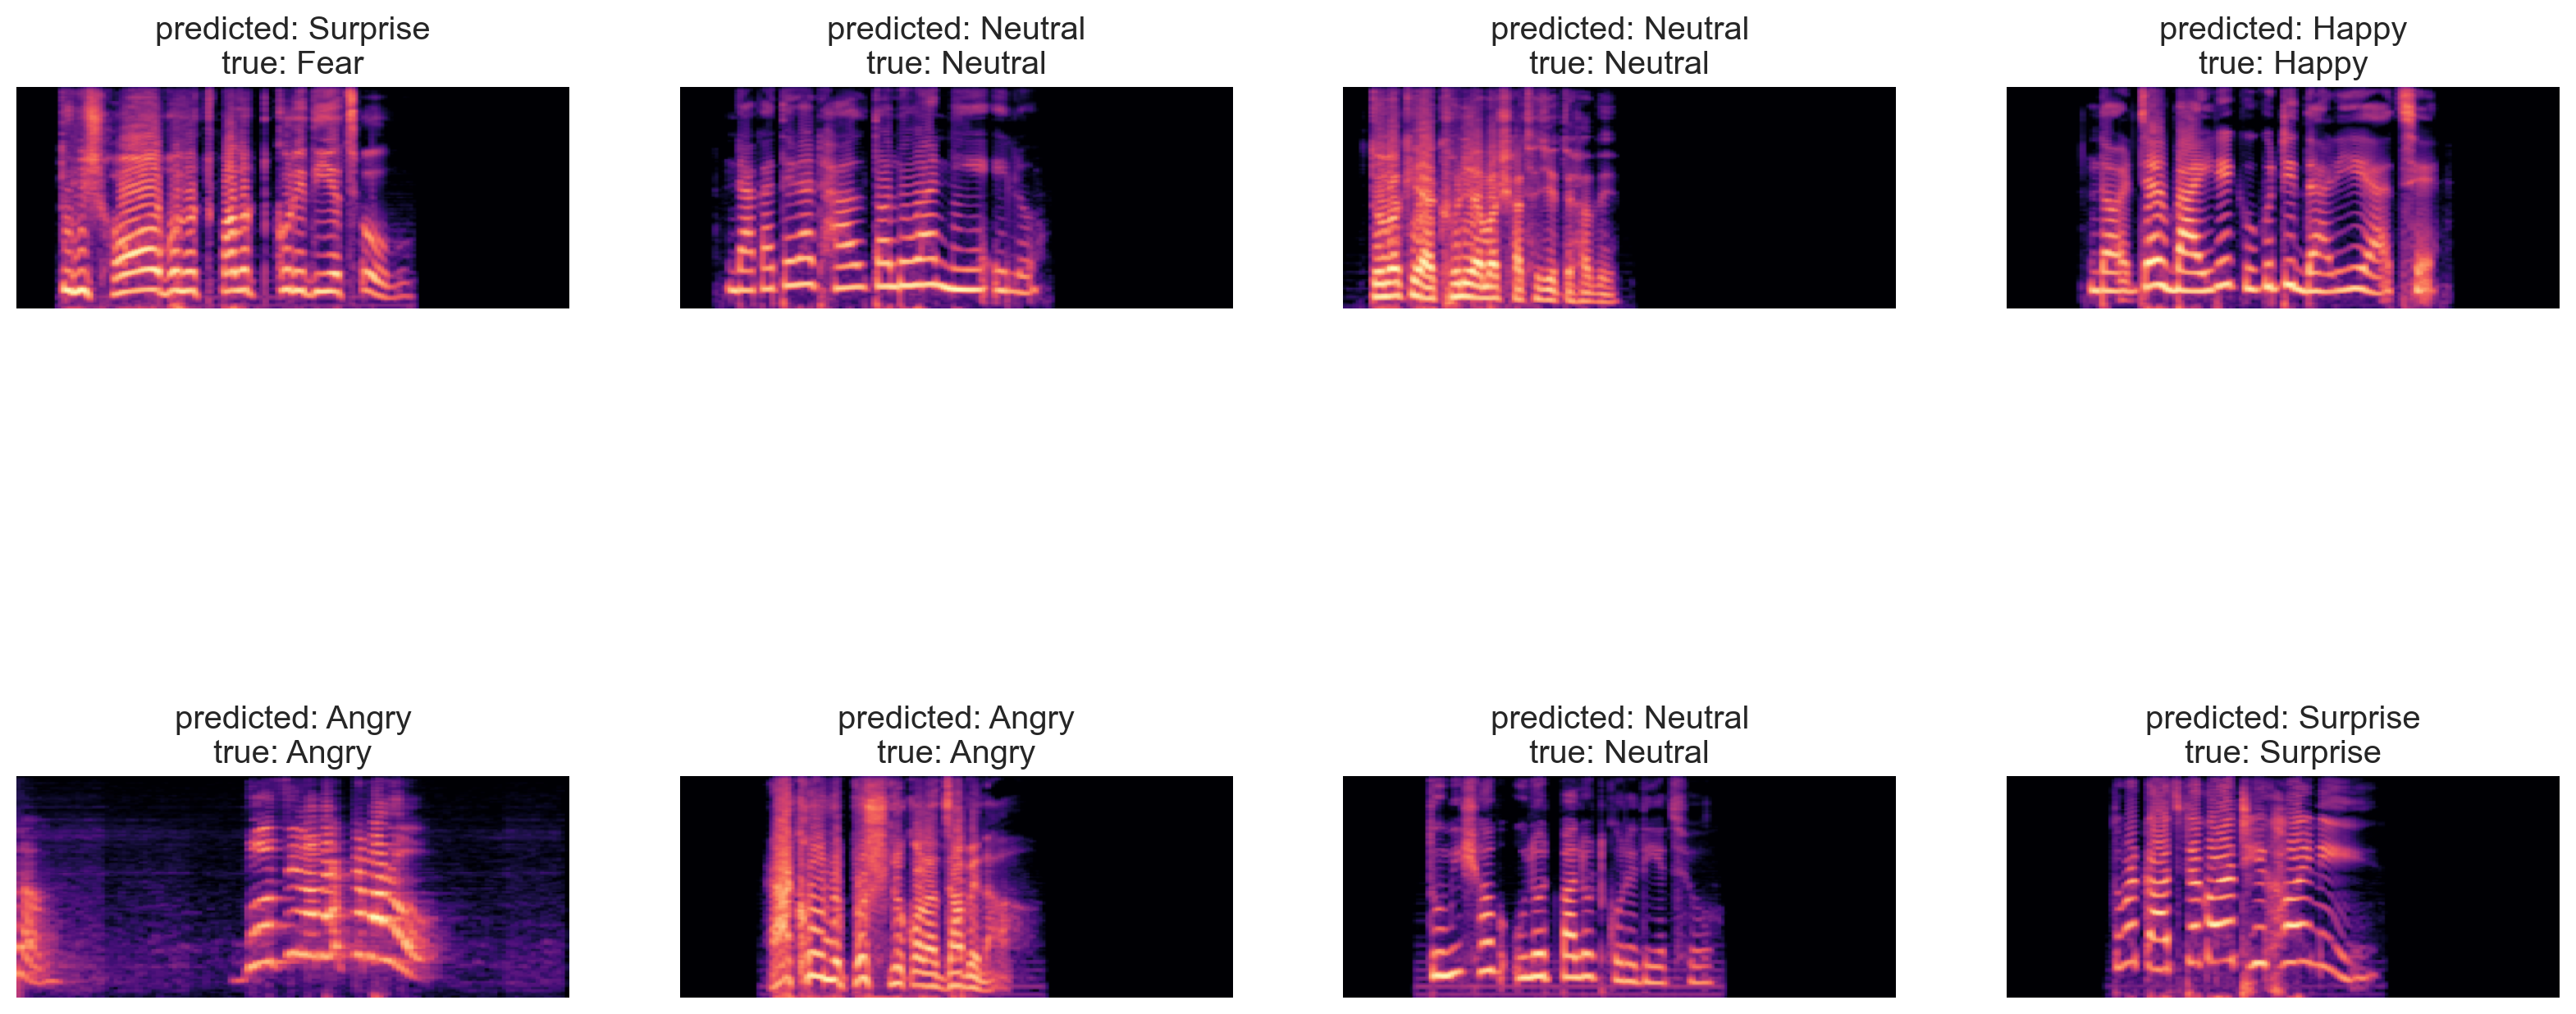

In [39]:
show_predictions(base_model, class_names, n_images=8)

In [40]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [41]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [42]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.94      0.89      0.92       151
     Disgust       0.85      0.84      0.85       120
        Fear       0.97      0.93      0.95       100
       Happy       0.84      0.90      0.87       151
     Neutral       0.90      0.97      0.93       135
         Sad       0.94      0.89      0.91       151
    Surprise       0.89      0.89      0.89       131

    accuracy                           0.90       939
   macro avg       0.90      0.90      0.90       939
weighted avg       0.90      0.90      0.90       939



In [43]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

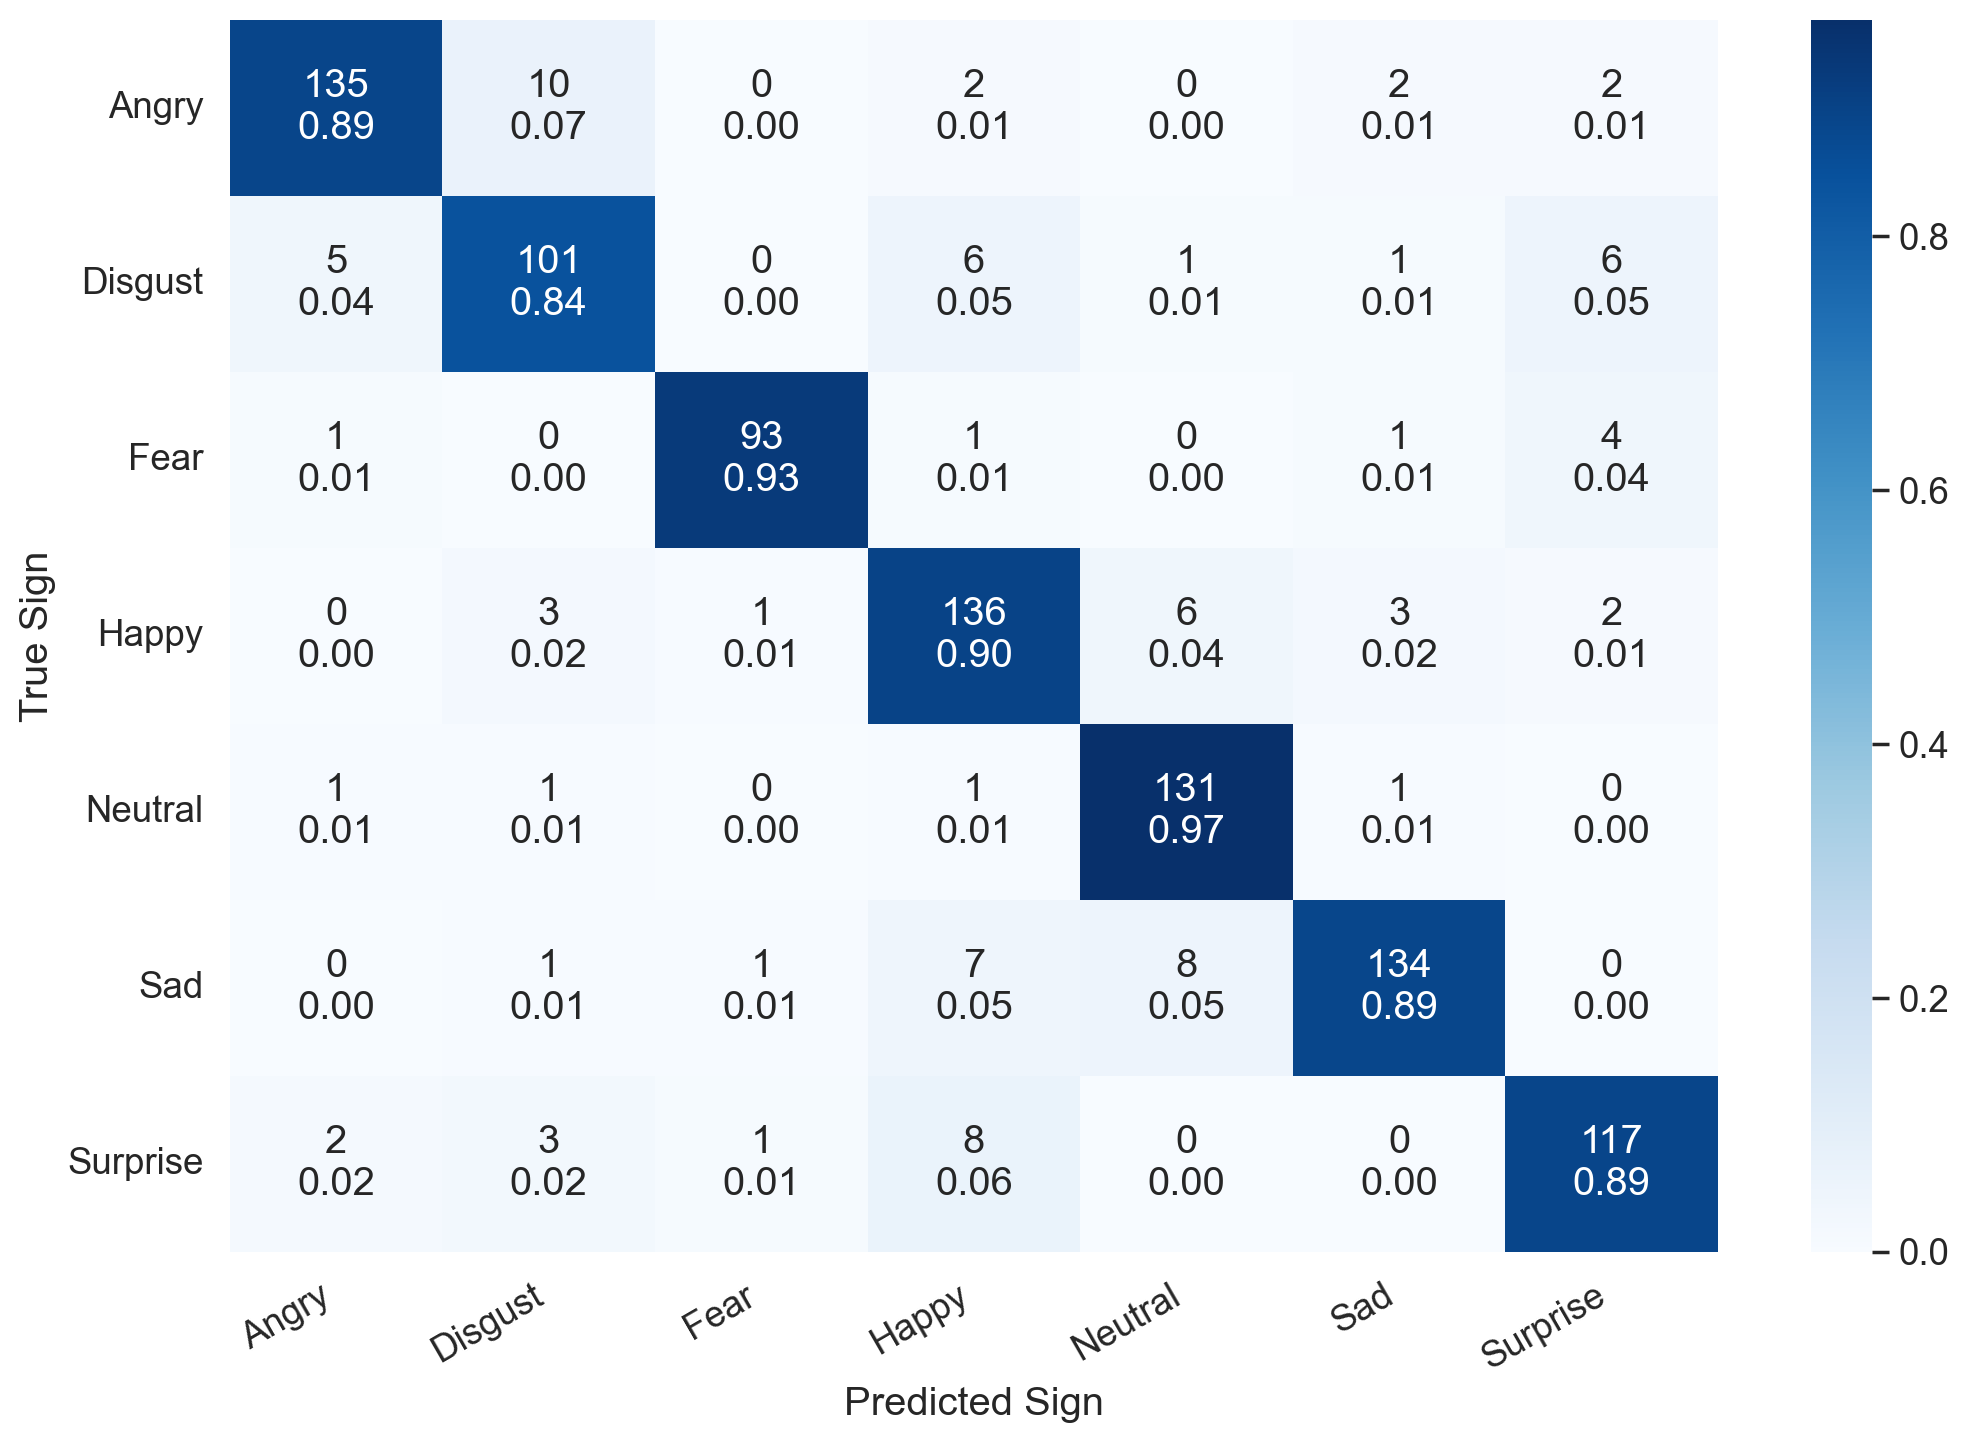

In [44]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)